<a href="https://colab.research.google.com/github/ColinCMach/LearningPytorch/blob/main/Going_Modular_Part2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.makedirs("going_modular", exist_ok = True)

In [ ]:
import os 
import zipfile
from pathlib import Path
import requests

#setup path to data folder

data_path = Path("data/")
image_path = data_path /"pizza_steak_sushi"

# if the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists ")
else:
  print(f"did not find{image_path} directory, creating one")
  image_path.mkdir(parents = True, exist_ok = True)

 # downloading the pizza, steak, sushi data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
   request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
   print("downloading the data")
   f.write(request.content)

# Unzipping the pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping the data")
  zip_ref.extractall(image_path)

os.remove("/content/data/pizza_steak_sushi.zip")

did not finddata/pizza_steak_sushi directory, creating one
downloading the data
unzipping the data


In [ ]:
train_dir = image_path /"train"
test_dir = image_path / "test"
train_dir

PosixPath('data/pizza_steak_sushi/train')

## Create dataset amd dataloaders


In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# create simple stransforms

data_transform = transforms.Compose([transforms.Resize(size = (64,64)), transforms.ToTensor() ])

# USe the imagefolder to create a dataset(s)
train_data = datasets.ImageFolder(root = train_dir, transform = data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = test_dir, transform = data_transform)



In [ ]:
class_names = train_data.classes

In [ ]:
class_dict = train_data.class_to_idx
class_dict


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(batch_size = BATCH_SIZE, dataset = train_data, num_workers = NUM_WORKERS,shuffle = True)
test_dataloader = DataLoader(batch_size = BATCH_SIZE , num_workers = NUM_WORKERS, dataset = test_data, shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f2730e81590>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2730e815d0>)

### Creatae dataset and dataloaders 
Rather than rewriting all of the code above we wanted to load the data we can turn it inco a script called data_setup.py

Lets capture all of the above functionality called create_dataloader()

In [ ]:
%%writefile going_modular/data_setup.py
#Contains functionality for creating pytorch dataloders for image classifcation data

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = os.cpu_count()

def create_dataloders(train_dir: str, test_dir:str, transform:transforms.Compose,batch_size:int, num_workers:int=NUM_WORKERS):
  train_data = datasets.ImageFolder(train_dir, transform = transform)
  test_data = datasets.ImageFolder(test_dir, transform = transform)

  # get the class class_names
  class_names = train_data.classes

  # Turn the images into DataLoader
  train_dataloader = DataLoader(train_data, batch_size = batch_size , num_workers = NUM_WORKERS,shuffle = True, pin_memory = True)
  test_dataloader = DataLoader(test_data, batch_size = batch_size , num_workers = NUM_WORKERS, shuffle = False, pin_memory = True)
  return train_dataloader, test_dataloader , class_names

Writing going_modular/data_setup.py


In [ ]:
import torch

from torch import nn 

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# 1. get a batch of images and labels from the dataloader
img_batch, label_batch = next(iter(train_dataloader))
import matplotlib.pyplot as plt
print(img_batch.shape)
img_single , label_single = img_batch[0].unsqueeze(dim = 0), label_batch[0]
print(f"single image shape:{img_single.shape}")

# perform the forward pass
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(img_single)
  print(f"The model transform the raw prediction is these logits {y_logits}")
  print(f" The dimensions after the forward pass are {y_logits.shape}")

torch.Size([32, 3, 64, 64])
single image shape:torch.Size([1, 3, 64, 64])
The model transform the raw prediction is these logits tensor([[ 0.0208, -0.0019,  0.0095]])
 The dimensions after the forward pass are torch.Size([1, 3])


In [ ]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch

from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

Writing going_modular/model_builder.py


In [ ]:
import torch

from going_modular import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model_1 = model_builder.TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                                hidden_units=10, 
                                output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0208, -0.0019,  0.0095]])

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]])

Output prediction label:
tensor([0])

Actual label:
0


In [ ]:
from typing import Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    
    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()
  
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    
    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 
  
  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  
  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
  
          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          
          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
          
  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from typing import Dict, List

from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
from typing import Dict, List, Tuple

import torch

from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:
    
    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()
  
  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:
    
    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 
  
  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  
  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
  
          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          
          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
          
  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Writing going_modular/engine.py


In [ ]:
%%writefile going_modular/utils.py
"""
File containing various utility functions for PyTorch model training.
""" 
import torch

from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  
  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  
  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing going_modular/utils.py


In [ ]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  
  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  
  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# Save the model
save_model(model=model_0,
           target_dir="models",
           model_name="05_going_modular_cell_mode_tinyvgg_model.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.2907
Epoch: 2 | train_loss: 1.0995 | train_acc: 0.3320 | test_loss: 1.0698 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0863 | train_acc: 0.4922 | test_loss: 1.0800 | test_acc: 0.5227
Epoch: 4 | train_loss: 1.0825 | train_acc: 0.4102 | test_loss: 1.0599 | test_acc: 0.5729
Epoch: 5 | train_loss: 1.0630 | train_acc: 0.4141 | test_loss: 1.0612 | test_acc: 0.5540
[INFO] Total training time: 13.000 seconds
[INFO] Saving model to: models/05_going_modular_cell_mode_tinyvgg_model.pth


### NOW ISTS TIME TO TRAIN AND EVALUALE THE SAME MODEL(SCIRPT MODE) -> TRAIN.PY

LETS CREATE A FILE CALLED TRAIN.PY TO LEVERAGE ALL OF OUR OTHER CODE SCRPUTIS TO TRAIN A PYTORCH MODEL 

ESSENTIALLY WE WATNT TO REPLACE ALL OUF OUT FUNCVTIONALIOTY OF NOTEBOOK 04 IN ONE LINE

In [ ]:
%%writefile going_modular/train.py 

# train a pytorch image classification modelk using device agnostic code

import os
import torch
from torch import nn
from torchvision import transforms
from timeit import default_timer as timer

import data_setup , engine , model_builder, utils

# setup hyper parameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_UNITS = 10 
LR = 0.001

# set upo directories
train_dir = "/content/data/pizza_steak_sushi/train"
test_dir = "/content/data/pizza_steak_sushi/test"

# setr up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# create transforms
data_transforms = transforms.Compose([transforms.Resize(size = (64,64)), 
                                      transforms.ToTensor()])

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = data_transforms,
                                                                              batch_size = BATCH_SIZE)
# create model
model = model_builder.TinyVGG(3,10,len(class_names)).to(device)

# set up loss and optimizer functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# start the time

start_time = timer()

# start training with help from the engine.oy
engine.train(model = model, train_dataloader= train_dataloader, test_dataloader = test_dataloader, loss_fn = loss_fn,optimizer = optimizer, epochs = NUM_EPOCHS, device = device)
end_time = timer()
print(f"INFO - Total training time :{end_time - start_time:.3f} seconds")

# save the model to a file
utils.save_model(model = model, target_dir = "models", model_name = "Saved_model.pth")

Writing going_modular/train.py


In [ ]:
!python going_modular/train.py

  0% 0/20 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1080 | train_acc: 0.2734 | test_loss: 1.0909 | test_acc: 0.2708
  5% 1/20 [00:01<00:37,  2.00s/it]Epoch: 2 | train_loss: 1.0922 | train_acc: 0.3750 | test_loss: 1.0966 | test_acc: 0.2708
 10% 2/20 [00:04<00:36,  2.04s/it]Epoch: 3 | train_loss: 1.0843 | train_acc: 0.4062 | test_loss: 1.0904 | test_acc: 0.3324
 15% 3/20 [00:06<00:34,  2.02s/it]Epoch: 4 | train_loss: 1.0748 | train_acc: 0.6133 | test_loss: 1.0805 | test_acc: 0.3722
 20% 4/20 [00:08<00:32,  2.04s/it]Epoch: 5 | train_loss: 1.0493 | train_acc: 0.6055 | test_loss: 1.0471 | test_acc: 0.4612
 25% 5/20 [00:10<00:30,  2.04s/it]Epoch: 6 | train_loss: 1.0486 | train_acc: 0.4727 | test_loss: 0.9903 | test_acc: 0.5559
 30% 6/20 [00:12<00:28,  2.03s/it]Epoch: 7 | train_loss: 1.0524 | train_acc: 0.4531 | test_loss: 1.0393 | test_acc: 0.3409
 35% 7/20 [00:14<00:26,  2.02s/it]Epoch: 8 | train_loss: 0.9459 | train_acc: 0.6016 | test_loss: 1.1241 | test_acc: 0.2917
 40% 8/20 [00:16<00:26, 

In [ ]:
loaded_model = model_0.load_state_dict(torch.load("/content/models/Saved_model.pth"))
img , label = train_data[20]
loaded_model.eval()
with torch.inference_mode():
  y_pred = loaded_model(img.unsqueeze(dim = 0))
print(f"modelk predications are {class_names[y_pred.argmax(dim= 1)]}")
print(f" the actual label is {class_names[label]}")
plt.imshow(img.permute(1,2,0))

AttributeError: ignored

modelk predications are pizza
 the actual label is pizza


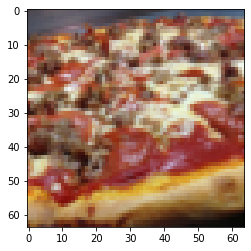

In [ ]:
import random
loaded_model = TinyVGG(3,10,len(class_names)).to(device)
loaded_model.load_state_dict(torch.load("/content/models/Saved_model.pth"))
img , label = train_data[random.randint(1,100)]
loaded_model.eval()
with torch.inference_mode():
  y_pred = loaded_model(img.unsqueeze(dim = 0))
print(f"modelk predications are {class_names[y_pred.argmax(dim= 1)]}")
print(f" the actual label is {class_names[label]}")
plt.imshow(img.permute(1,2,0))

In [ ]:
import random
random.randint(1,100)

16